In [5]:
from textblob import TextBlob
import requests, math, time
import csv, pathlib
import pandas as pd
import os
import openai
import json
import seaborn as sns
import json
import sys
import warnings
import spacy

# Suppress all warnings
warnings.filterwarnings("ignore")

In [6]:
print("This program uses an ML natural language model (GPT-3) to summarize and analyze articles in the NYT\nto summarize and do sentiment analysis on a given subject, person, or location (or any other keyword) over time")
print("\nYou can input your query using natural language like this: \nSearch all articles about Michael Jackson from 1990 to his death")
print("\nSearch all articles about Enron since its IPO up to its collapse")

print("\nNote: If you want detailed and accurate answers, it is better to include the dates in the query.")

This program uses an ML natural language model (GPT-3) to summarize and analyze articles in the NYT
to summarize and do sentiment analysis on a given subject, person, or location (or any other keyword) over time

You can input your query using natural language like this: 
Search all articles about Michael Jackson from 1990 to his death

Search all articles about Enron since its IPO up to its collapse

Note: If you want detailed and accurate answers, it is better to include the dates in the query.


In [7]:
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

In [8]:
# Open the JSON file in read mode (OpenAI)
with open("..//api_key.json", "r") as f:
    # Load the JSON data from the file
    data = json.load(f)
    # Get the API key from the JSON data
    api_key = data["api_key"]

# Set the API key
openai.api_key = api_key

In [9]:
#Open the JSON files in read mode (NYT API Key)
with open("..//nyt_key.json", "r") as f:
    # Load the JSON data from the file
    data = json.load(f)
    # Get the API key from the JSON data
    api_key = data["api_key"]

# Set the API key
nyt_key = api_key

In [10]:
query = str(input("Enter the search query: "))

In [11]:
#turning the response from natural language to objects that are readable by the NYT API
response_keyword = openai.Completion.create(
  model="text-davinci-003",
  prompt="Find the main keyword (a name, a location, etc) from this query and nothing else: " + query,
  temperature=0.7,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

keyword = response_keyword.choices[0].text

def remove_leading_trailing_spaces(obj):
    # Use the strip() method to remove leading and trailing spaces
    return obj.strip()

keyword = remove_leading_trailing_spaces(keyword)

response_date = openai.Completion.create(
  model="text-davinci-003",
  prompt="In number format, and adding no extra text tell me the year, month, day (YYYYMMDD) relevant to this query (there should be two dates, beggining and end separated by a single comma). If no indication of time in query, output NA. Years start on 0101 and end 1231. If no end date, add today's date: " + query,
  temperature=0.5,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

dates = response_date.choices[0].text

# Split the input string into a list of dates
dates = dates.split(",")

# Assign the first date to begin_date
begin_date = dates[0]

# Assign the second date to end_date
end_date = dates[1]

# We need to remove all spaces and non-numeric characters
begin_date = ''.join([c for c in begin_date if c.isdigit()])
end_date = ''.join([c for c in end_date if c.isdigit()])

In [12]:
# Adding + signs for entries with multiple words
def format_keyword(keyword):
    # Split the keyword into a list of words
    words = keyword.split()
    
    # Join the words with a + separator
    formatted_keyword = "+".join(words)
    
    return formatted_keyword

keyword = format_keyword(keyword)

In [13]:
#checking out outputs
print(keyword)
print(begin_date)
print(end_date)

Steve+Sinofsky
20120923
20130923


In [14]:
# SEARCH ARTICLES FUNCTION WORKS
def search_articles(api_key, keyword, begin_date, end_date):
    # Set up the parameters for the API request
    base_url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={keyword}'

    # Create an empty dataframe to store the results
    df = pd.DataFrame()

    # Set the number of pages to retrieve
    num_pages = 10

    # Perform the API request for each page
    for page in range(num_pages):
        params = {
            'api-key': nyt_key,
            'q': keyword,
            'page': page,
            'begin_date': begin_date,
            'end_date': end_date
        }
        response = requests.get(base_url, params=params)
        data = response.json()

        # Add the articles to the dataframe
        for article in data['response']['docs']:
            df = df.append(article, ignore_index=True)
    
    return df

In [15]:
df = search_articles(nyt_key, keyword, begin_date, end_date)


In [16]:
base_url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={keyword}'

if begin_date:
    base_url += f'&begin_date={begin_date}'
if end_date:
    base_url += f'&end_date={end_date}'
    
    
base_url

'https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Steve+Sinofsky&begin_date=20120923&end_date=20130923'

In [21]:
df

,abstract,web_url,snippet,lead_paragraph,source,multimedia,headline,keywords,pub_date,document_type,...,section_name,byline,type_of_material,_id,word_count,uri,print_section,print_page,text,sentiment
0,The announcement of Steven Sinofsky’s ouster f...,https://bits.blogs.nytimes.com/2012/11/13/why-...,The announcement of Steven Sinofsky’s ouster f...,The announcement of Steven Sinofsky’s ouster f...,The New York Times,"[{'rank': 0, 'subtype': 'blog480', 'caption': ...","{'main': 'Why Sinofsky Left: A Web Roundup', '...","[{'name': 'subject', 'value': 'Computers and t...",2012-11-13 15:56:15+00:00,article,...,Technology,"{'original': 'By The New York Times', 'person'...",News,nyt://article/ddabc819-d162-5b96-86b6-394fc35b...,664,nyt://article/ddabc819-d162-5b96-86b6-394fc35b...,NaN,NaN,The announcement of Steven Sinofsky’s ouster f...,-0.132025
1,A slide in the sales of Microsoft’s flagship W...,https://bits.blogs.nytimes.com/2012/10/09/miss...,A slide in the sales of Microsoft’s flagship W...,A slide in the sales of Microsoft’s flagship ...,The New York Times,"[{'rank': 0, 'subtype': 'blog480', 'caption': ...",{'main': 'Missteps Curb Microsoft Bonuses for ...,"[{'name': 'subject', 'value': 'Executive Compe...",2012-10-09 22:49:09+00:00,article,...,Technology,"{'original': 'By Nick Wingfield', 'person': [{...",News,nyt://article/1ea3c334-0c34-5c88-8347-683089e3...,481,nyt://article/1ea3c334-0c34-5c88-8347-683089e3...,NaN,NaN,A slide in the sales of Microsoft’s flagship W...,-0.235000
2,Wednesday’s highlights from around the Web inc...,https://bits.blogs.nytimes.com/2013/08/22/toda...,Wednesday’s highlights from around the Web inc...,"Every day, The New York Times’s staff scours t...",The New York Times,"[{'rank': 0, 'subtype': 'blog480', 'caption': ...",{'main': 'Today’s Scuttlebot: Former Windows B...,[],2013-08-22 22:21:19+00:00,article,...,Technology,"{'original': 'By The New York Times', 'person'...",News,nyt://article/fe6588be-cd2c-5331-b0ea-d00d1804...,332,nyt://article/fe6588be-cd2c-5331-b0ea-d00d1804...,NaN,NaN,Wednesday’s highlights from around the Web inc...,0.041761
3,Microsoft threw a coming-out party for Windows...,https://bits.blogs.nytimes.com/2012/10/25/live...,Microsoft threw a coming-out party for Windows...,Microsoft threw a coming-out party on Thursday...,The New York Times,"[{'rank': 0, 'subtype': 'blog480', 'caption': ...",{'main': 'Updates From Microsoft’s Windows 8 a...,"[{'name': 'subject', 'value': 'Tablet Computer...",2012-10-25 14:37:31+00:00,article,...,Technology,"{'original': 'By Nick Wingfield', 'person': [{...",News,nyt://article/fc470c5f-128b-58c8-a960-495f0ce1...,970,nyt://article/fc470c5f-128b-58c8-a960-495f0ce1...,NaN,NaN,Microsoft threw a coming-out party for Windows...,0.107168
4,"Microsoft, the world’s best-known software com...",https://www.nytimes.com/2012/10/26/technology/...,"Microsoft, the world’s best-known software com...","Microsoft, the world’s best-known software com...",The New York Times,"[{'rank': 0, 'subtype': 'blog480', 'caption': ...",{'main': 'A New Tablet Puts Microsoft in a Del...,"[{'name': 'subject', 'value': 'Windows (Operat...",2012-10-25 21:59:27+00:00,article,...,Technology,"{'original': 'By Nick Wingfield', 'person': [{...",News,nyt://article/a6c6656b-a92e-5ce3-ad5c-0eadbddb...,740,nyt://article/a6c6656b-a92e-5ce3-ad5c-0eadbddb...,B,3,"Microsoft, the world’s best-known software com...",-0.215000
5,Some documentary directors are wondering if a ...,https://www.nytimes.com/2012/10/04/movies/docu...,Some documentary directors are wondering if a ...,A month and a half spent watching nearly 100 m...,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'Flaws Seen in New Rules for Oscars',...","[{'name': 'persons', 'value': 'Moore, Michael ...",2012-10-03 21:58:36+00:00,article,...,Movies,"{'original': 'By Dave Itzkoff', 'person': [{'f...",News,nyt://article/0081d3b8-1e5b-5936-852b-4852a8ac...,1034,nyt://article/0081d3b8-1e5b-5936-852b-4852a8a

<AxesSubplot:xlabel='pub_date', ylabel='sentiment'>

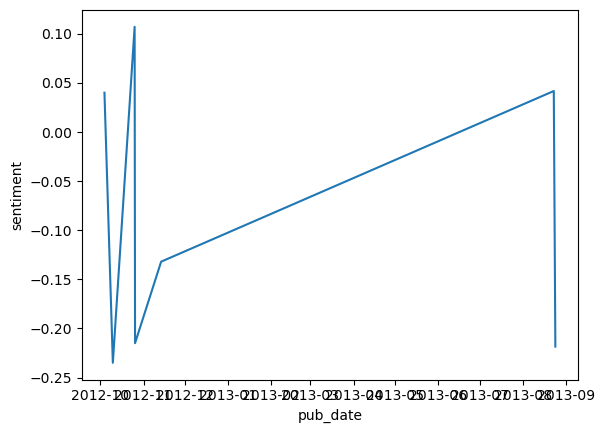

In [18]:
#Sentiment Analysis and Seaborn code

# Combine the three columns into one
df["text"] = df["abstract"].astype(str) + df["lead_paragraph"].astype(str) + df["byline"].astype(str)


# Create a new column for the sentiment scores
df["sentiment"] = df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Format the pub_date column as a date
df["pub_date"] = pd.to_datetime(df["pub_date"])

# Plot the sentiment scores over time
sns.lineplot(x="pub_date", y="sentiment", data=df)


AttributeError: 'Line2D' object has no property 'height'

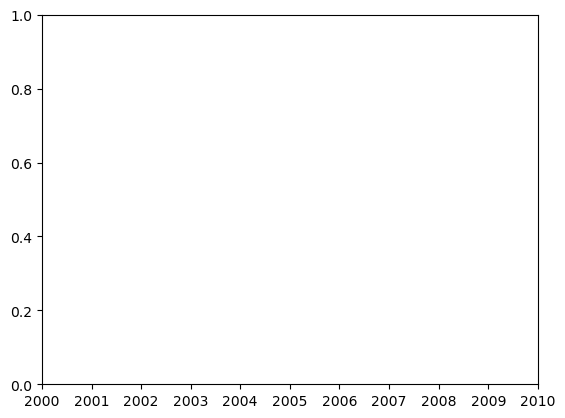

In [20]:
# Corrected plot
sns.lineplot(
    data=df, 
    x="pub_date", y="sentiment",
    height=5, aspect=2 
)


In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()
doc = nlp("This is a sentence.")
print([(w.text, w.pos_) for w in doc])

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [1]:
# sentiment analysis using spacy
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Combine the three columns into one
df["text"] = df["abstract"].astype(str) + df["lead_paragraph"].astype(str) + df["byline"].astype(str)

# Create a new column for the sentiment scores
df["sentiment"] = df["text"].apply(lambda x: nlp(x).sentiment)

# Format the pub_date column as a date
df["pub_date"] = pd.to_datetime(df["pub_date"])

# Plot the sentiment scores over time
sns.lineplot(x="pub_date", y="sentiment", data=df)


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [16]:
print(df.columns)

Index(['abstract', 'web_url', 'snippet', 'lead_paragraph', 'print_section',
       'print_page', 'source', 'multimedia', 'headline', 'keywords',
       'pub_date', 'document_type', 'news_desk', 'section_name',
       'subsection_name', 'byline', 'type_of_material', '_id', 'word_count',
       'uri', 'text', 'sentiment'],
      dtype='object')


In [17]:
# Convert the pub_date column to datetime
df['pub_date'] = pd.to_datetime(df['pub_date'])

# Extract only the date part of the datetime
df['pub_date'] = pd.DatetimeIndex(df['pub_date']).date

In [18]:
# Convert the pub_date column to datetime
df['pub_date'] = pd.to_datetime(df['pub_date'])
print(df['pub_date'].dtype)

# Extract only the date part of the datetime
df['pub_date'] = pd.DatetimeIndex(df['pub_date']).date

datetime64[ns]


In [19]:
# Let's filter dates
# Convert the string to a datetime
date = pd.to_datetime('2016-11-29')

# Select articles with a pub_date on or before January 1, 2020
df_filtered = df.loc[df['pub_date'] <= date]

In [20]:
df_filtered

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,...,news_desk,section_name,subsection_name,byline,type_of_material,_id,word_count,uri,text,sentiment
0,How Steve Jobs used his Apple millions to turn...,https://www.nytimes.com/2008/06/22/books/revie...,How Steve Jobs used his Apple millions to turn...,Great paradigm-shifting narratives  entrepren...,BR,13,The New York Times,"[{'rank': 0, 'subtype': 'articleInline', 'capt...","{'main': 'Success Story 2', 'kicker': None, 'c...","[{'name': 'organizations', 'value': 'Disney, W...",...,BookReview,Books,Book Review,"{'original': 'By Michael Hirschorn', 'person':...",Review,nyt://article/eaa284e7-cc8a-53a7-8672-8dbcd0ba...,1268,nyt://article/eaa284e7-cc8a-53a7-8672-8dbcd0ba...,How Steve Jobs used his Apple millions to turn...,0.025000
1,Apple C.E.O. Steve Jobs discusses the new iPho...,https://www.nytimes.com/video/technology/11948...,Apple C.E.O. Steve Jobs discusses the new iPho...,Apple C.E.O. Steve Jobs discusses the new iPho...,NaN,NaN,The New York Times,"[{'rank': 0, 'subtype': 'wide', 'caption': Non...","{'main': 'Apple's iPhone 2.0', 'kicker': None,...","[{'name': 'organizations', 'value': 'Apple Inc...",...,,Technology,NaN,"{'original': None, 'person': [], 'organization...",Video,nyt://video/cc53239f-df10-5c98-b6ab-6a70a92b0daf,0,nyt://video/cc53239f-df10-5c98-b6ab-6a70a92b0daf,Apple C.E.O. Steve Jobs discusses the new iPho...,0.149621
2,The company announced a new version of the iPh...,https://www.nytimes.com/2008/06/10/technology/...,The company announced a new version of the iPh...,"SAN FRANCISCO  Steven P. Jobs, chief executiv...",C,4,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Apple Aims for the Masses With a Che...,"[{'name': 'organizations', 'value': 'Apple Inc...",...,Business,Technology,NaN,"{'original': 'By John Markoff', 'person': [{'f...",News,nyt://article/d0434bf5-d120-5ff1-801a-e40c54c0...,848,nyt://article/d0434bf5-d120-5ff1-801a-e40c54c0...,The company announced a new version of the iPh...,0.026629
3,A lot of us carry a little bit of Steve Jobs a...,https://www.nytimes.com/2008/05/05/business/me...,A lot of us carry a little bit of Steve Jobs a...,I don’t own my iPod. It owns me.,C,1,The New York Times,"[{'rank': 0, 'subtype': 'wide', 'caption': Non...","{'main': 'Steve Jobs Stakes Out the TV Den', '...","[{'name': 'subject', 'value': 'DVD (Digital Ve...",...,Business,Business Day,Media,"{'original': 'By David Carr', 'person': [{'fir...",News,nyt://article/c8ef438e-7137-5246-9a9f-249dfefe...,1262,nyt://article/c8ef438e-7137-5246-9a9f-249dfefe...,A lot of us carry a little bit of Steve Jobs a...,-0.027083
4,"Buoyed by unusually strong Macintosh sales, th...",https://www.nytimes.com/2008/04/24/technology/...,"Buoyed by unusually strong Macintosh sales, th...",SAN FRANCISCO  Signs of a consumer slowdown a...,C,1,The New York Times,"[{'rank': 0, 'subtype': 'popup', 'caption': No...",{'main': 'Apple Riding a 51% Jump in Mac Sales...,"[{'name': 'subject', 'value': 'Company Reports...",...,Business,Technology,NaN,"{'original': 'By John Markoff', 'person': [{'f...",News,nyt://article/3eefc4be-e49a-567b-92f2-070059b7...,890,nyt://article/3eefc4be-e49a-567b-92f2-070059b7...,"Buoyed by unusually strong Macintosh sales, th...",0.001389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Though it has been widely reported that Bear S...,https://dealbook.nytimes.com/2008/04/30/at-bea...,,Though it has been widely reported that Bear S...,NaN,NaN,The New York Times,[],"{'main': 'At Bear, Letters Bring Good News and...",[],...,Business,Business Day,NaN,"{'original': 'By Dealbook', 'person': [{'first...",News,nyt://article/c0ec6402-66bd-52a2-96b4-1a25e89d...,229,nyt://article/c0ec6402-66bd-52a2-96b4-1a25e89d...,Though it has been widely reported that Bear S...,-0.244048
96,"AT&T, the exclusive carrier for the iPhone sai...",https://bits.blogs.nyti

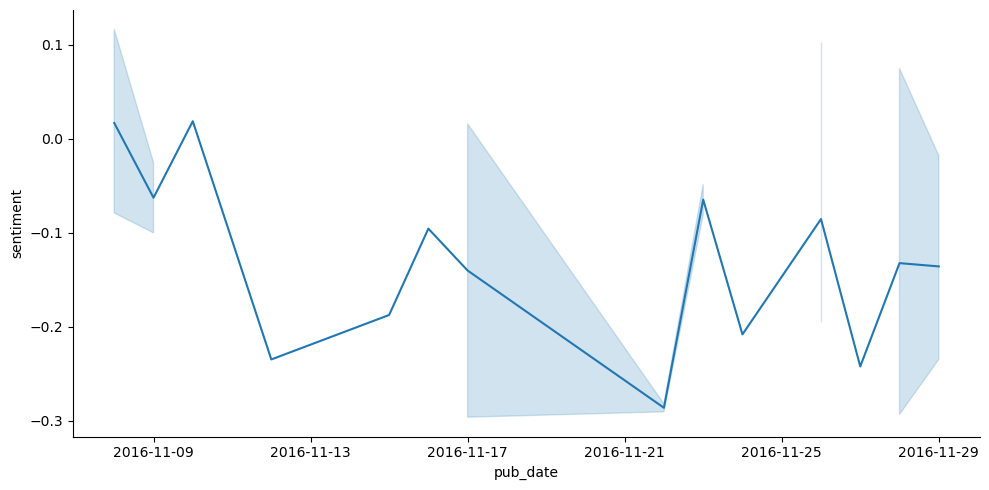

In [99]:
#filtered plot
# better plot
sns.relplot(
    data=df_filtered, 
    x="pub_date", y="sentiment",
    kind="line",
    height=5, aspect=2 
)